### Dictionary Product

In [3]:
from itertools import product


options = {'name': 'Device',
           'diff_methods': (1, 2),
           'interfaces': ('i1', 'i2'),
           'simulator': '11',
           }

options['qubit_count'] = 3


    
iterable_options = []
    
for option, variants in options.items():
    
    if not hasattr(variants, '__iter__') or isinstance(variants, str):
        
        options = ((option, variants),)
        
    else:

        options = tuple(product([option], variants))
    
    iterable_options.append(options)

print("iterable_options:", iterable_options)

options_combinations = list(map(dict, product(*iterable_options)))
    
# print(options_list)

for options_combination in options_combinations:
    
    print(options_combination)

print(options_combinations)

iterable_options: [(('name', 'Device'),), (('diff_methods', 1), ('diff_methods', 2)), (('interfaces', 'i1'), ('interfaces', 'i2')), (('simulator', '11'),), (('qubit_count', 3),)]
{'name': 'Device', 'diff_methods': 1, 'interfaces': 'i1', 'simulator': '11', 'qubit_count': 3}
{'name': 'Device', 'diff_methods': 1, 'interfaces': 'i2', 'simulator': '11', 'qubit_count': 3}
{'name': 'Device', 'diff_methods': 2, 'interfaces': 'i1', 'simulator': '11', 'qubit_count': 3}
{'name': 'Device', 'diff_methods': 2, 'interfaces': 'i2', 'simulator': '11', 'qubit_count': 3}
[{'name': 'Device', 'diff_methods': 1, 'interfaces': 'i1', 'simulator': '11', 'qubit_count': 3}, {'name': 'Device', 'diff_methods': 1, 'interfaces': 'i2', 'simulator': '11', 'qubit_count': 3}, {'name': 'Device', 'diff_methods': 2, 'interfaces': 'i1', 'simulator': '11', 'qubit_count': 3}, {'name': 'Device', 'diff_methods': 2, 'interfaces': 'i2', 'simulator': '11', 'qubit_count': 3}]


### FM Forward Functions

In [6]:
def forward_weight_indices(self, inputs):

    batch_size, fields_length = inputs.shape        

    predictions = torch.zeros(batch_size)        

    for input_index, fields in enumerate(inputs):

        weight_indices = torch.nonzero(fields).squeeze()

        selected_weights = self.single_embedding(weight_indices)

        coupling_matrix = torch.matmul(selected_weights, selected_weights.T)

        upper_right_couplings = torch.triu(coupling_matrix, diagonal=1)

        prediction = upper_right_couplings.sum()

        # print("weight_indices:", weight_indices.shape, weight_indices)     
        # print("selected_weights:", selected_weights.shape, selected_weights) 
        # print("coupling_matrix:", coupling_matrix.shape, coupling_matrix)
        # print("upper_right_couplings:", upper_right_couplings.shape, upper_right_couplings)
        # print("prediction:", prediction)

        predictions[input_index] = prediction

    # print("predictions:", predictions.shape, predictions)

    return predictions


def forward_triu_loop(self, inputs):

    batch_size, fields_length = inputs.shape        

    predictions = torch.zeros(batch_size)        

    for input_index, fields in enumerate(inputs):

        fields_matrix = torch.outer(fields, fields)

        upper_right_fields = torch.triu(fields_matrix, diagonal=1)

        fields_indices = torch.tensor(range(len(fields)))

        embedding_matrix = self.single_embedding(fields_indices)

        coupling_matrix = torch.matmul(embedding_matrix, embedding_matrix.T)

        # masked_weights = coupling_matrix * fields_matrix
        # prediction = masked_weights.sum() / 2

        masked_weights = coupling_matrix * upper_right_fields
        prediction = masked_weights.sum()

        # print("fields_matrix:", fields_matrix.shape, fields_matrix)     
        # print("upper_right_fields:", upper_right_fields.shape, upper_right_fields) 
        # print("fields_indices:", fields_indices)
        # print("embedding_matrix:", embedding_matrix.shape, embedding_matrix)
        # print("coupling_matrix:", coupling_matrix.shape, coupling_matrix)
        # print("masked_weights:", masked_weights.shape, masked_weights)
        # print("prediction:", prediction)

        predictions[input_index] = prediction

    # print("predictions:", predictions.shape, predictions)

    return predictions


def forward_vectorized(self, inputs):

    masked_weights = inputs.unsqueeze(2) * self.single_embedding.weight

    coupling_matrices = masked_weights @ masked_weights.mT

    masked_coupling_matrices = coupling_matrices.triu(diagonal=1)

    predictions = masked_coupling_matrices.sum(dim=(1, 2))    

    # print("inputs:", inputs.shape, inputs)     
    # print("self.single_embedding.weight:", self.single_embedding.weight.shape, self.single_embedding.weight) 
    # print("masked_weights:", masked_weights.shape, masked_weights)
    # print("coupling_matrices:", coupling_matrices.shape, coupling_matrices)
    # print("masked_coupling_matrices:", masked_coupling_matrices.shape, masked_coupling_matrices)           
    # print("predictions:", predictions.shape, predictions)

    return predictions


def forward(self, inputs):

    masked_weights = inputs.unsqueeze(2) * self.single_embedding.weight

    square_of_sum = masked_weights.sum(dim=1) ** 2

    sum_of_squares = (masked_weights ** 2).sum(dim=1)

    predictions = 0.5 * (square_of_sum - sum_of_squares).sum(dim=1)

    # print("inputs:", inputs.shape, inputs)     
    # print("self.single_embedding.weight:", self.single_embedding.weight.shape, self.single_embedding.weight) 
    # print("masked_weights:", masked_weights.shape, masked_weights)
    # print("square_of_sum:", square_of_sum.shape, square_of_sum)
    # print("sum_of_squares:", sum_of_squares.shape, sum_of_squares)           
    # print("predictions:", predictions.shape, predictions)

    return predictions

### D-Wave - Maximum Independent Set - QUBO

{(0, 0): -1.0,
 (1, 1): -1.0,
 (2, 2): -1.0,
 (3, 3): -1.0,
 (4, 4): -1.0,
 (0, 1): 2.0,
 (1, 2): 2.0,
 (2, 3): 2.0,
 (3, 4): 2.0}

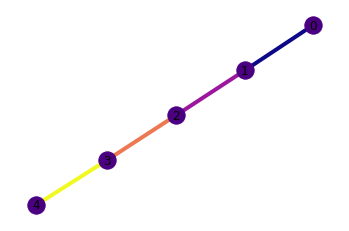

In [8]:
# Import networkx for graph tools
import networkx as nx

from dwave_networkx.algorithms.independent_set import maximum_weighted_independent_set
from dwave_networkx.algorithms.independent_set import maximum_weighted_independent_set_qubo

from matplotlib import pyplot as plt

graph = nx.path_graph(5)

# Node coordinates
positions = nx.kamada_kawai_layout(graph)

# Edge color range
edge_colors = range(graph.number_of_edges())

# Do not draw plot frame
plt.axis('off')

# Draw
nx.draw_networkx(G=graph, 
                 pos=positions, 
                 # with_labels=False, 
                 edge_cmap=plt.cm.plasma, 
                 edge_color=edge_colors,
                 # node_size=0,
                 node_color='indigo',
                 width=4)

Q = maximum_weighted_independent_set_qubo(graph, weight='weight', lagrange=2.0)

Q

In [10]:
lagrange = 2.0

cost = dict(graph.nodes(data=None, default=1))
scale = max(cost.values())

Q = {(node, node): min(-cost[node] / scale, 0.0) for node in graph}
Q.update({edge: lagrange for edge in graph.edges})

Q

{(0, 0): -1.0,
 (1, 1): -1.0,
 (2, 2): -1.0,
 (3, 3): -1.0,
 (4, 4): -1.0,
 (0, 1): 2.0,
 (1, 2): 2.0,
 (2, 3): 2.0,
 (3, 4): 2.0}

### Lightning Qubit Multi-Threaded

In [5]:
# import pennylane as qml
# import numpy as np
# from time import time
# import os

# n_wires = 28
# n_layers = 200

# # Measure time for lightning.gpu

# start_timing = time() * 1000

# dev = qml.device("lightning.gpu", wires=n_wires)
# @qml.qnode(dev, diff_method="adjoint")
# def circuit(weights):
#     qml.StronglyEntanglingLayers(weights, wires=range(n_wires))
#     return [qml.expval(qml.PauliZ(i)) for i in range(n_wires)]
# param_shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
# params = np.random.random(param_shape)
# jac = qml.jacobian(circuit)(params)

# print("lighting.gpu:")
# print(f"{round(time() * 1000 - start_timing, 3)} ms")

# # Measure time for lightning.qubit with 1 thread

# os.environ["OMP_NUM_THREADS"] = "1"
# start_timing = time() * 1000

# dev = qml.device("lightning.qubit", wires=n_wires)
# @qml.qnode(dev, diff_method="adjoint")
# def circuit(weights):
#     qml.StronglyEntanglingLayers(weights, wires=list(range(n_wires)))
#     return [qml.expval(qml.PauliZ(i)) for i in range(n_wires)]
# param_shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
# params = np.random.random(param_shape)
# jac = qml.jacobian(circuit)(params)

# print("lighting.qubit with 1 thread:")
# print(f"{round(time() * 1000 - start_timing, 3)} ms")

# # Measure time for lightning.qubit with 32 threads

# start_timing = time() * 1000
# os.environ["OMP_NUM_THREADS"] = "32"

# dev = qml.device("lightning.qubit", wires=n_wires)
# @qml.qnode(dev, diff_method="adjoint")
# def circuit(weights):
#     qml.StronglyEntanglingLayers(weights, wires=list(range(n_wires)))
#     return [qml.expval(qml.PauliZ(i)) for i in range(n_wires)]
# param_shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
# params = np.random.random(param_shape)
# jac = qml.jacobian(circuit)(params)

# print("lighting.qubit 32 threads:")
# print(f"{round(time() * 1000 - start_timing, 3)} ms")

### Logo Table

In [ ]:
# <table width="100%" border="0" cellpadding="10" cellspacing="0">
#     <tr>
#     	<td align="center" height="40px">
#             <a><img 
#             src="https://developer.nvidia.com/sites/default/files/akamai/nvidia-cuquantum-icon.svg" 
#             height="60" 
#             alt="cuQuantum logo">
#             </a>
#         </td>
#     	<td align="center" height="40px">
#             <a><img 
#             src="https://jax.readthedocs.io/en/latest/_static/jax_logo_250px.png" 
#             height="40"
#             alt="JAX logo">
#             </a>
#         </td>
#     	<td align="center">
#             <a><img 
#             src="https://github.com/unitaryfund/mitiq/blob/master/docs/source/img/mitiq-logo.png?raw=true"
#             height="40"
#             alt="Mitiq logo">
#             </a>
#         </td>
#     </tr>
# </table>